In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from transformers import InputExample, InputFeatures
import logging
logging.basicConfig(level=logging.ERROR)

/home/csci8523/hwan0259/.conda/envs/pytorch_gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-21 09:45:50.340267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set up device for gpu usage or cpu usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import io
train=pd.read_csv("../Dataset/SA_dataset/train.tsv", sep="\t", on_bad_lines='skip')
test=pd.read_csv("../Dataset/SA_dataset/test.tsv", sep="\t", on_bad_lines='skip')
test_check=pd.read_csv("../Dataset/SA_dataset/test_check.csv", sep=",", on_bad_lines='skip')
print(train.head())
print(test.head())
print(test_check.head())

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  
   PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly

In [4]:
# df_train = train
# df_test = test
# df_test_c = test_check

df_train = train
df_test = test
df_test_c = test_check

In [5]:
df_train["Sentiment"].unique()

array([1, 2, 3, 4, 0])

In [6]:
extracted_col = df_test_c["Sentiment"]
df_test = df_test.join(extracted_col)
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,2
1,156062,8545,An intermittently pleasing but mostly routine ...,2
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,2
4,156065,8545,intermittently pleasing but mostly routine,2


In [7]:
df_train = df_train[['Phrase', 'Sentiment']]
df_test = df_test[['Phrase', 'Sentiment']]
df_test.head()

,Phrase,Sentiment
0,An intermittently pleasing but mostly routine ...,2
1,An intermittently pleasing but mostly routine ...,2
2,An,2
3,intermittently pleasing but mostly routine effort,2
4,intermittently pleasing but mostly routine,2


In [8]:
#Check longest string in Phrase
print(df_train.Phrase.str.len().max())
print(df_test.Phrase.str.len().max())

283
256


In [9]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 283
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

LEARNING_RATE = 5e-5
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [10]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

</s> 2
<s> 0
<pad> 1
<unk> 3


In [11]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Phrase
        self.targets = self.data.Sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        targets = self.targets[index]

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True, # add [CLS], [SEP]
            max_length = self.max_len, # max length of the text that can go to BERT
            pad_to_max_length = True, # add [PAD] tokens
            return_attention_mask = True, # add attention mask to not focus on pad tokens
            return_token_type_ids=False ,
            return_tensors='pt',
            truncation=True
        )


        return {
            'phrase': text,
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'targets': torch.tensor(targets, dtype=torch.long)
        }

In [12]:
df_train = df_train.dropna()
df_test = df_test.dropna()
df_test

,Phrase,Sentiment
0,An intermittently pleasing but mostly routine ...,2
1,An intermittently pleasing but mostly routine ...,2
2,An,2
3,intermittently pleasing but mostly routine effort,2
4,intermittently pleasing but mostly routine,2
...,...,...
66287,"A long-winded , predictable scenario .",2
66288,"A long-winded , predictable scenario",2
66289,"A long-winded ,",2
66290,A long-winded,2


In [13]:
train_size = 0.8
train_data=df_train.sample(frac=train_size,random_state=200)
valid_data=df_train.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)
test_data = df_test.reset_index(drop=True)

In [14]:
print(train_data[train_data['Phrase'] == ' '].index)
print(valid_data[valid_data['Phrase'] == ' '].index)
len(valid_data)
valid_data = valid_data.drop(407)
valid_data= valid_data.reset_index(drop=True)

Int64Index([], dtype='int64')
Int64Index([407], dtype='int64')


In [15]:
train_set = SentimentData(train_data, tokenizer, MAX_LEN)
valid_set = SentimentData(valid_data, tokenizer, MAX_LEN)
test_set = SentimentData(df_test, tokenizer, MAX_LEN)

print("TRAIN Dataset: {}".format(train_data.shape))
print("VALID Dataset: {}".format(valid_data.shape))
print("TEST Dataset: {}".format(df_test.shape))

TRAIN Dataset: (124848, 2)
VALID Dataset: (31211, 2)
TEST Dataset: (66292, 2)


In [16]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 4
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 4
                }
test_params = {'batch_size': TEST_BATCH_SIZE,
               'shuffle': True,
                'num_workers': 4
                }


train_loader = DataLoader(train_set, **train_params)
valid_loader = DataLoader(valid_set, **valid_params)
test_loader = DataLoader(test_set, **test_params)

In [17]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [18]:
model = RobertaClass()
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [19]:
# Creating the loss function and optimizer
EPOCHS = 1

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [20]:

# Function for a single training iteration
def train_epoch(model, training_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    step = 0
    for d in tqdm(training_loader):
        step = step+1
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        #scheduler.step()
        optimizer.zero_grad()
    
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
%%time
import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        len(train_set)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        valid_loader,
        loss_fn,
        device,
        len(valid_set)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'RoBERTa_SA_Model')
        best_accuracy = val_acc

Epoch 1/1
----------


100%|██████████| 1951/1951 [24:26<00:00,  1.33it/s]


Train loss 0.8412962126340822 accuracy 0.6515843265410739


100%|██████████| 488/488 [02:07<00:00,  3.83it/s]


Val   loss 0.7411638786558246 accuracy 0.6926404152382174

CPU times: user 15min 9s, sys: 11min 28s, total: 26min 38s
Wall time: 26min 35s


In [32]:
list1= []
for t_ac in history['train_acc']:
    t_ac = torch.Tensor.cpu(t_ac).numpy()
    list1.append(t_ac)

list2= []
for t_va in history['val_acc']:
    t_va = torch.Tensor.cpu(t_va).numpy()
    list2.append(t_va)

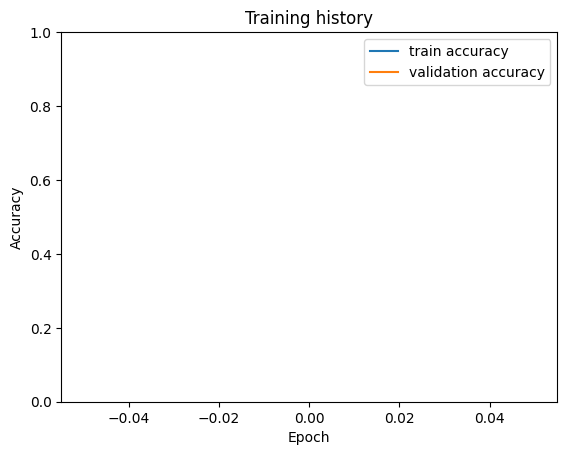

In [33]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy

plt.plot(list1, label='train accuracy')
plt.plot(list2, label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [34]:
model.load_state_dict(torch.load('RoBERTa_SA_Model'))

<All keys matched successfully>

In [35]:
# Get model performance (accuracy and loss)
test_acc, test_loss = eval_model(
  model,
  test_loader,
  loss_fn,
  device,
  len(test_set)
)

100%|██████████| 1036/1036 [04:29<00:00,  3.85it/s]


In [36]:
test_acc.item()

0.582694744463887

In [37]:
#Example of sentiment analysis

In [38]:
review_text = "I love completing my todos! Best app ever!!!"

In [39]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [31]:
# sentiment
# 0 - 4
# one of five labels (from very negative to very positive)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)


output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {prediction.item()}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : 4
